<a href="https://colab.research.google.com/github/RAHULSKILLER/iNT_project/blob/main/Anomaly_Detection_with_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Anomaly Detection with LSTM Autoencoder on NASA C-MAPSS Dataset

In [ ]:
# Step 1: Install dependencies (Colab usually has these)
!pip install pandas numpy scikit-learn tensorflow


In [ ]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
# Step 3: Upload the dataset
from google.colab import files
uploaded = files.upload()


Saving train_FD001.txt to train_FD001 (2).txt


In [ ]:
# Step 4: Load the dataset (adjust file name if different)
file_name = 'train_FD001.txt'
columns = ['unit_number', 'time_in_cycles'] + \
          [f'operational_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_{i}' for i in range(1, 22)]
df = pd.read_csv(file_name, sep='\s+', header=None, names=columns)


In [ ]:
# Step 5: Normalize sensor data
sensor_cols = [col for col in df.columns if "sensor" in col]
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [ ]:
# Step 6: Prepare training sequences from early healthy cycles
sequence_length = 30
normal_data = []

for unit in df['unit_number'].unique():
    unit_data = df[df['unit_number'] == unit].sort_values('time_in_cycles')
    early_cycles = unit_data[unit_data['time_in_cycles'] <= 50]
    for i in range(len(early_cycles) - sequence_length):
        seq = early_cycles.iloc[i:i+sequence_length][sensor_cols].values
        normal_data.append(seq)

normal_data = np.array(normal_data)
normal_data.shape


(2000, 30, 21)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Define model parameters
input_dim = len(sensor_cols)
timesteps = sequence_length

# Build the Autoencoder model
input_layer = Input(shape=(timesteps, input_dim))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)
bottleneck = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(bottleneck)
output = TimeDistributed(Dense(input_dim))(decoded)

# Define and compile the model
autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the Autoencoder
history = autoencoder.fit(normal_data, normal_data,
                          epochs=20,
                          batch_size=32,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 0.1029 - val_loss: 0.0104
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0091 - val_loss: 0.0047
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0

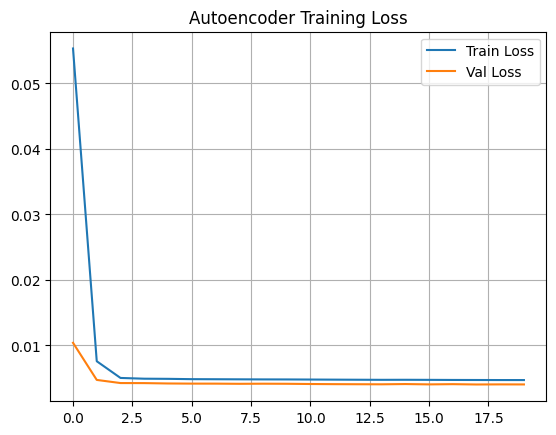

In [ ]:
# Step 8: Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Upload test_FD001.txt
from google.colab import files
uploaded = files.upload()

# Make sure file name matches exactly
file_name = 'test_FD001.txt'  # Adjust if needed

# Load and normalize test data
test_df = pd.read_csv(file_name, sep='\\s+', header=None, names=columns)
test_df[sensor_cols] = scaler.transform(test_df[sensor_cols])  # Use same scaler

# Create sequences from test data
test_sequences = []
test_indices = []

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit].sort_values('time_in_cycles')
    for i in range(len(unit_data) - sequence_length):
        seq = unit_data.iloc[i:i+sequence_length][sensor_cols].values
        test_sequences.append(seq)
        test_indices.append(unit_data.iloc[i+sequence_length-1][['unit_number', 'time_in_cycles']].values)

test_sequences = np.array(test_sequences)

# Predict with trained Autoencoder
reconstructions = autoencoder.predict(test_sequences)

# Calculate reconstruction error
mse = np.mean(np.power(test_sequences - reconstructions, 2), axis=(1, 2))

# Create DataFrame for analysis
test_error_df = pd.DataFrame(test_indices, columns=["unit_number", "time_in_cycles"])
test_error_df["reconstruction_error"] = mse

# Set threshold (95th percentile of error)
threshold = np.percentile(mse, 95)
test_error_df["anomaly"] = test_error_df["reconstruction_error"] > threshold

# Show first few anomalies
test_error_df[test_error_df["anomaly"] == True].head()

Saving test_FD001.txt to test_FD001 (1).txt
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


,unit_number,time_in_cycles,reconstruction_error,anomaly
626,10.0,30.0,0.009762,True
627,10.0,31.0,0.010789,True
628,10.0,32.0,0.010852,True
629,10.0,33.0,0.009627,True
630,10.0,34.0,0.010631,True


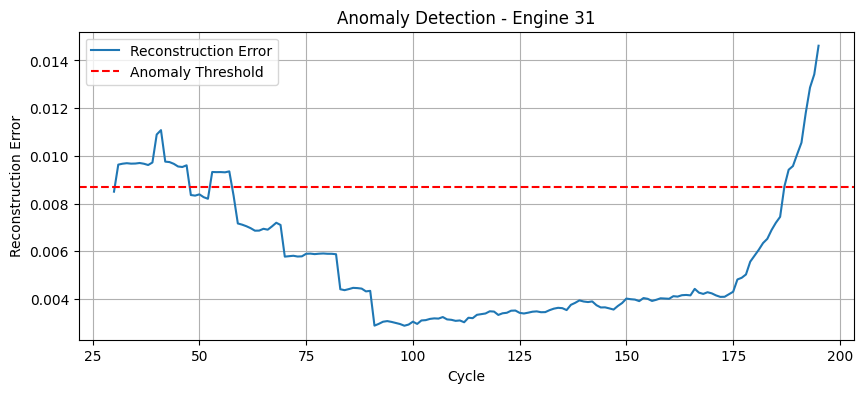

In [ ]:
import matplotlib.pyplot as plt

# Plot reconstruction error for a specific engine
unit_id = 31
unit_data = test_error_df[test_error_df["unit_number"] == unit_id]

plt.figure(figsize=(10, 4))
plt.plot(unit_data["time_in_cycles"], unit_data["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.title(f"Anomaly Detection - Engine {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()

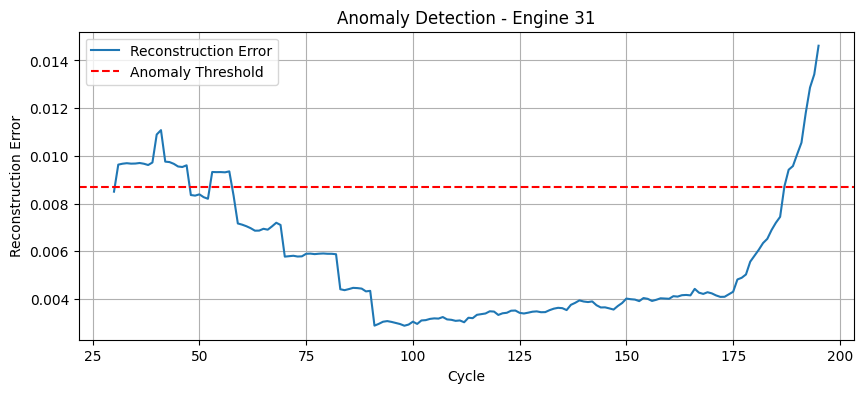

In [ ]:
unit_id = 31

unit_data = test_error_df[test_error_df["unit_number"] == unit_id]

plt.figure(figsize=(10, 4))
plt.plot(unit_data["time_in_cycles"], unit_data["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.title(f"Anomaly Detection - Engine {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()

316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


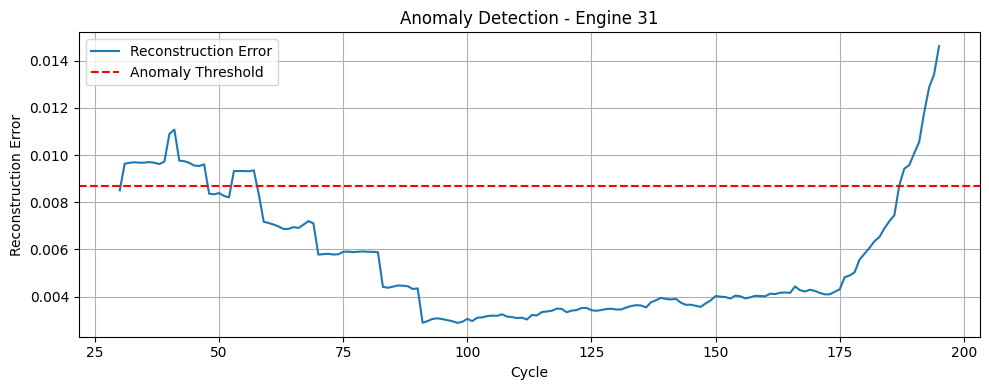

In [ ]:
# Task 1.6: Compute reconstruction error on test sequences
reconstructions = autoencoder.predict(test_sequences)
reconstruction_error = np.mean(np.power(test_sequences - reconstructions, 2), axis=(1, 2))

# Task 1.7: Define a threshold (95th percentile of training reconstruction error)
threshold = np.percentile(reconstruction_error, 95)

# Task 1.8: Flag anomalies
test_error_df = pd.DataFrame(test_indices, columns=["unit_number", "time_in_cycles"])
test_error_df["reconstruction_error"] = reconstruction_error
test_error_df["anomaly"] = test_error_df["reconstruction_error"] > threshold

# Task 1.9: Visualize anomaly trend for a specific engine
unit_id = 31  # You can change this to another engine number
unit_data = test_error_df[test_error_df["unit_number"] == unit_id]

plt.figure(figsize=(10, 4))
plt.plot(unit_data["time_in_cycles"], unit_data["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.title(f"Anomaly Detection - Engine {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


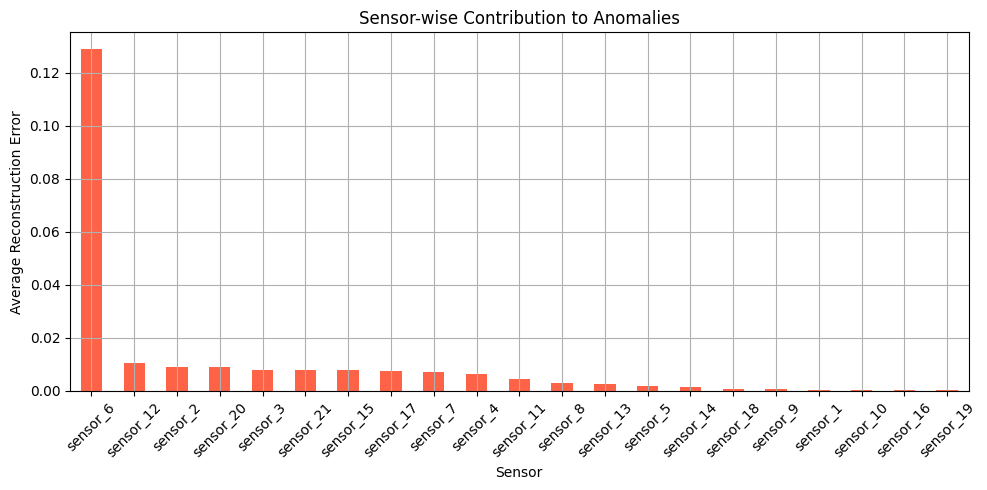

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute reconstruction error for each sensor
# Shape: (num_sequences, 21 sensors)
sensor_wise_error = np.mean(np.square(test_sequences - reconstructions), axis=1)

# Step 2: Convert to DataFrame
sensor_error_df = pd.DataFrame(sensor_wise_error, columns=sensor_cols)
sensor_error_df["unit_number"] = [int(i[0]) for i in test_indices]
sensor_error_df["time_in_cycles"] = [int(i[1]) for i in test_indices]

# Step 3: Filter anomalies only
sensor_error_df["reconstruction_error"] = np.mean(np.square(test_sequences - reconstructions), axis=(1, 2))
threshold = np.percentile(sensor_error_df["reconstruction_error"], 95)
anomalous_data = sensor_error_df[sensor_error_df["reconstruction_error"] > threshold]

# Step 4: Calculate average error per sensor across all anomalies
avg_sensor_error = anomalous_data[sensor_cols].mean().sort_values(ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 5))
avg_sensor_error.plot(kind='bar', color='tomato')
plt.title("Sensor-wise Contribution to Anomalies")
plt.ylabel("Average Reconstruction Error")
plt.xlabel("Sensor")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Run predictions
reconstructions = autoencoder.predict(test_sequences)

# Step 2: Compute reconstruction error per sensor
sensor_wise_error = np.mean(np.square(test_sequences - reconstructions), axis=1)  # shape: (samples, 21)

# Step 3: Create DataFrame of sensor-wise errors + metadata
sensor_error_df = pd.DataFrame(sensor_wise_error, columns=sensor_cols)
sensor_error_df["unit_number"] = [int(i[0]) for i in test_indices]
sensor_error_df["time_in_cycles"] = [int(i[1]) for i in test_indices]
sensor_error_df["total_error"] = np.mean(np.square(test_sequences - reconstructions), axis=(1, 2))

# Step 4: Set 95th percentile threshold per sensor
sensor_thresholds = sensor_error_df[sensor_cols].quantile(0.95)

# Step 5: Filter by specific engine
engine_id = 31  # change as needed
engine_data = sensor_error_df[sensor_error_df["unit_number"] == engine_id].copy()

# Step 6: Flag per-sensor anomalies
for sensor in sensor_cols:
    engine_data[f"{sensor}_anomaly"] = engine_data[sensor] > sensor_thresholds[sensor]
    engine_data[f"{sensor}_threshold"] = sensor_thresholds[sensor]

# Step 7: Filter only rows where total error is above threshold
anomaly_threshold = sensor_error_df["total_error"].quantile(0.95)
engine_anomalies = engine_data[engine_data["total_error"] > anomaly_threshold]

# Step 8: Show relevant columns
cols_to_show = ["unit_number", "time_in_cycles", "total_error"] + \
               [col for col in engine_anomalies.columns if "_anomaly" in col or "_threshold" in col or col in sensor_cols]

engine_anomalies[cols_to_show].reset_index(drop=True)


316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


,unit_number,time_in_cycles,total_error,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_17_anomaly,sensor_17_threshold,sensor_18_anomaly,sensor_18_threshold,sensor_19_anomaly,sensor_19_threshold,sensor_20_anomaly,sensor_20_threshold,sensor_21_anomaly,sensor_21_threshold
0,31,31,0.009634,0.000015,0.006050,0.006195,0.005113,0.000231,0.137860,0.005071,...,False,0.009564,False,0.000151,True,0.000187,False,0.009752,False,0.010567
1,31,32,0.009673,0.000020,0.007027,0.006735,0.005259,0.000352,0.138156,0.005190,...,False,0.009564,False,0.000151,True,0.000187,False,0.009752,False,0.010567
2,31,33,0.009694,0.000024,0.006958,0.007203,0.005406,0.000254,0.138461,0.004821,...,False,0.009564,False,0.000151,True,0.000187,False,0.009752,False,0.010567
3,31,34,0.009675,0.000016,0.007232,0.007847,0.005189,0.000288,0.138443,0.004606,...,False,0.009564,False,0.000151,True,0.000187,False,0.009752,False,0.010567
4,31,35,0.009680,0.000008,0.007221,0.007715,0.005101,0.000263,0.138492,0.004288,...,False,0.009564,False,0.000151,True,0.000187,False,0.009752,False,0.010567
5,31,36,0.009703,0.000004,0.008571,0.007361,0.004764,0.000234,0.138524,0.004015,...,False,0.009564,False,0.000151,False,0.000187,False,0.009752,False,0.010567
6,31,37,0.009671,0.000014,0.007391,0.007798,0.004572,0.000273,0.138442,0.003927,...,False,0.009564,False,0.000151,True,0.000187,False,0.009752,False,0.010567
7,31,38,0.009618,0.000010,0.007412,0.007973,0.004540,0.000271,0.138624,0.003809,...,False,0.009564,False,0.000151,False,0.000187,False,0.009752,False,0.010567
8,31,39,0.009723,0.000004,0.007642,0.008595,0.005549,0.000305,0.138913,0.003911,...,False,0.009564,False,0.000151,False,0.000187,False,0.009752,False,0.010567
9,31,40,0.010896,0.000007,0.007661,0.009755,0.005517,0.000431,0.161613,0.003806,...,False,0.009564,False,0.000151,True,0.000187,False,0.009752,False,0.010567


In [ ]:
# Create a DataFrame for sensor descriptions
sensor_info = {
    "sensor": [f"sensor_{i}" for i in range(1, 22)],
    "description": [
        "Total temperature at fan inlet (T2)",
        "Total pressure at fan inlet (P2)",
        "Fan speed (Nf)",
        "Core speed (Nc)",
        "Engine pressure ratio (EPR)",
        "HPC outlet pressure",
        "Physical fan speed",
        "Physical core speed",
        "Bypass Ratio",
        "Burner pressure",
        "Bleed Enthalpy",
        "Bleed Cooling Air",
        "HPT Cooling Air",
        "LPT outlet temperature",
        "HPT outlet temperature",
        "LPT pressure ratio",
        "Fuel flow",
        "Airflow",
        "Oil pressure",
        "Oil temperature",
        "Engine vibration"
    ],
    "unit": [
        "°R", "psi", "rpm", "rpm", "ratio", "psi", "rpm", "rpm", "ratio", "psi",
        "BTU/lb", "mass flow", "mass flow", "°R", "°R", "ratio", "lb/hr", "lb/s",
        "psi", "°F", "g-force"
    ]
}

sensor_df = pd.DataFrame(sensor_info)
sensor_df


,sensor,description,unit
0,sensor_1,Total temperature at fan inlet (T2),°R
1,sensor_2,Total pressure at fan inlet (P2),psi
2,sensor_3,Fan speed (Nf),rpm
3,sensor_4,Core speed (Nc),rpm
4,sensor_5,Engine pressure ratio (EPR),ratio
5,sensor_6,HPC outlet pressure,psi
6,sensor_7,Physical fan speed,rpm
7,sensor_8,Physical core speed,rpm
8,sensor_9,Bypass Ratio,ratio
9,sensor_10,Burner pressure,psi


In [ ]:
# ✅ Full reconstruction of test_error_df for merging
import numpy as np
import pandas as pd

# Re-run the prediction and error computation
reconstructions = autoencoder.predict(test_sequences)
reconstruction_error = np.mean(np.square(test_sequences - reconstructions), axis=(1, 2))

# Rebuild test_error_df with proper merge columns
test_error_df = pd.DataFrame(test_indices, columns=["unit_number", "time_in_cycles"])
test_error_df["reconstruction_error"] = reconstruction_error

# Define anomaly threshold
threshold = np.percentile(reconstruction_error, 95)
test_error_df["anomaly"] = test_error_df["reconstruction_error"] > threshold

# Confirm fix
print("✅ test_error_df rebuilt with correct columns:")
print(test_error_df.columns)
print(test_error_df.head())


316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
✅ test_error_df rebuilt with correct columns:
Index(['unit_number', 'time_in_cycles', 'reconstruction_error', 'anomaly'], dtype='object')
   unit_number  time_in_cycles  reconstruction_error  anomaly
0          1.0            30.0              0.002604    False
1          2.0            30.0              0.003239    False
2          2.0            31.0              0.003239    False
3          2.0            32.0              0.003361    False
4          2.0            33.0              0.003273    False


In [1]:
# Merge with RUL + anomaly data and label conditions

# Merge RUL into df_test (if not done yet)
max_cycle_test = df_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycle_test["max_RUL"] = rul_df["RUL"]
df_test = df_test.merge(max_cycle_test, on="unit_number", how="left")
df_test["RUL"] = df_test["max_RUL"] - df_test["time_in_cycles"]
df_test.drop(columns=["max_RUL"], inplace=True)

# Normalize RUL as percent
df_test["RUL_percent"] = df_test.groupby("unit_number")["RUL"].transform(lambda x: x / x.max())

# Merge with the fixed test_error_df
df_test = df_test.merge(
    test_error_df[["unit_number", "time_in_cycles", "reconstruction_error", "anomaly"]],
    on=["unit_number", "time_in_cycles"],
    how="left"
)

# Label logic
def label_condition(row):
    if row["RUL_percent"] > 0.3 and not row["anomaly"]:
        return 0  # Healthy
    elif row["RUL_percent"] < 0.1 or row["reconstruction_error"] > test_error_df["reconstruction_error"].quantile(0.99):
        return 2  # Failing
    else:
        return 1  # Degraded

df_test["condition_label"] = df_test.apply(label_condition, axis=1)

# Confirm success
print("🎯 Final label distribution:")
print(df_test["condition_label"].value_counts())


NameError: name 'df_test' is not defined